#Loading the Image
In this section, image to be processed is loaded via openCV library in grayscale. Then, the matrix of the image is normalized to have 1 instead of 255 as foreground. In other words, matrix is converted from grayscale to binary.

Mounted at /content/drive


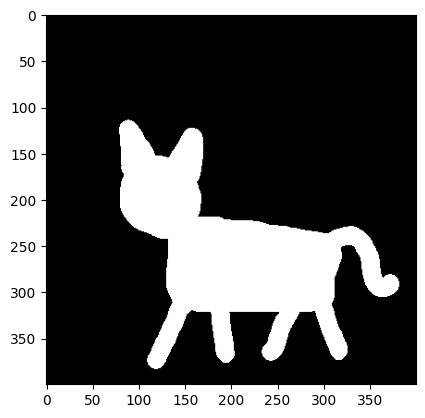

In [1]:
from google.colab import drive
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Path to the image in Google Drive
image_file = '/content/drive/My Drive/perfectly_painted_cat.png'

# Load the image
perfectly_painted_cat = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

# Normalize the image, convert from grayscale to binary
perfectly_painted_cat = (perfectly_painted_cat - np.min(perfectly_painted_cat)) / (np.max(perfectly_painted_cat) - np.min(perfectly_painted_cat))

plt.imshow(perfectly_painted_cat, cmap="gray")

#Utility Functions
This section contains the utility functions that will be used for mathematical morphology operations. These utilities are complementing, taking union and intersection.

In [2]:
def complement_for_binary(img):

    # Complements a binary image

    # Assuming the image is a numpy array
    img_height, img_width = img.shape

    # Array to store the complemented rows
    complemented_img = []

    for i in range(img_height):

        # Array to store the complemented elements of the new row
        complemented_row = []

        for j in range(img_width):

            # Append binary inverse of the row element
            if img[i, j] == 0:
                complemented_row.append(1)
            else:
                complemented_row.append(0)

        complemented_img.append(complemented_row)

    # Return the numpy array version of the new complemented image
    return np.array(complemented_img).astype(np.uint8)

In [3]:
def intersect_for_binary(img1, img2):

    # Takes the intersection of two binary images and returns the image with intersecting pixels

    # Assuming img1 and img2 are numpy arrays
    img1_height, img1_width = img1.shape
    img2_height, img2_width = img2.shape

    # To be able to take intersect, images must be of same size
    if img1_height != img2_height and img2_height != img2_width:
        print("Unequal shape detected at intersection:", img1.shape, img2.shape)
        return -1

    # Since the images are binary images, i.e. they either have 0 or 1 as elements,
    #  in the case of element-wise multiplication, only case that the result will be 1
    #  is when two pixels from the images are both 1, in other words, pixels are intersecting
    intersect_img = np.multiply(img1, img2).astype(np.uint8)

    return intersect_img

In [4]:
def union_for_binary(img1, img2):

    # Takes the union of two binary images and returns the unioned image with all foreground pixels in the union

    # Assuming img1 and img2 are numpy arrays
    img1_height, img1_width = img1.shape
    #img2_height, img2_width = img2.shape

    # To be able to take union, images must be of same size
    if img1.shape != img2.shape:
        print("Unequal shape detected at union:", img1.shape, img2.shape)
        return -1

    # As the images are binary, logical or operation can be used to take union
    #   Or operation would return 1 in all cases that at least one of the two
    #   pixels from the two images is 1, i.e. it would take the union of pixels
    union_img = np.logical_or(img1, img2).astype(np.uint8)
    return union_img

#Mathematical Morphology Operations
This section contains the implementations of the mathematical morphology operations needed for the convex hull algorithm. It includes the erosion, hit-or-miss and the convex hull. Thickening is covered in the convex hull function.

In [9]:
def erosion_for_binary(img, struct_elt):

    # Erosion is the operation that is in the base of convex hull algorithm
    # Thus, it is the first to be implemented

    # Assuming that both img and struct_elt are numpy arrays
    se_height, se_width = struct_elt.shape
    img_height, img_width = img.shape

    # Limit to check whether the SE fits into the window or not
    # It is basically the the number of pixels in the foreground
    fit_limit = np.sum(struct_elt)

    # How many times should the window shift down? (outer loop var)
    row_pass = img_height - se_height + 1
    # How many times should the window shift right? (inner loop var)
    column_pass = img_width - se_width + 1

    # How much padding will be needed after erosion to go back to original size?
    lost_pixel_height = (se_height - 1)//2
    lost_pixel_width = (se_width - 1)//2

    # Pixel values for the eroded image will be saved in this numpy array
    #   It includes the padding from the top
    eroded_img_np = [[0 for j in range(img_width)] for i in range(lost_pixel_height)]

    for i in range(row_pass):

        # A numpy array for the current row
        #   including the padding from right
        eroded_row = [0 for k in range(lost_pixel_width)]

        # Each inner iteration consturcts a row
        for j in range(column_pass):

            # Current window from the image
            patch = [img[k][j:j + se_width] for k in range(i, i + se_height)]

            # Multiply the window with SE to see whether SE fits into this patch
            #   Multiplication is basically taking intersection
            #   Since the background of SE is formed of 0s, only foreground will survive
            fit_matrix = np.multiply(np.array(patch), struct_elt)
            fit_check = np.sum(fit_matrix)

            # If the sum of the surviving 1s is equal to number of 1s in SE
            #   then the SE fits into the window, thus central pixel is in the foreground
            if fit_check == fit_limit:
                eroded_row.append(1)
            else:
                eroded_row.append(0)

        # Adding the padding value at the end of the row
        pad_from_left = [0 for k in range(lost_pixel_width)]
        eroded_row.extend(pad_from_left)
        eroded_img_np.append(eroded_row)

    # Adding the padding to from the bottom
    pad_from_bottom = [[0 for j in range(img_width)] for i in range(lost_pixel_height)]
    eroded_img_np.extend(pad_from_bottom)

    # Returning the eroded and padded image in numpy form
    return np.array(eroded_img_np)

In [6]:
def hit_or_miss_for_binary(img, SE_foreground, SE_background):

    # Implements the hit-or-miss operation
    #   i.e., checks whether foreground and background of SE fits to
    #   window of image foreground and background exactly
    #   and erodes if not
    #   It is achieved via intersection of erosion of foreground of image and erosion of background of image
    #   with related part of the SE

    # Assuming that both img and struct_elt are numpy arrays
    # Image complement for the background check
    img_comp = complement_for_binary(img)

    # Foreground check with erosion
    foreground_erosion = erosion_for_binary(img, SE_foreground)
    # Background check with erosion
    background_erosion = erosion_for_binary(img_comp, SE_background)

    # Intersecting foreground and background results for the final image
    HorM_img = intersect_for_binary(foreground_erosion, background_erosion)

    return HorM_img

In [7]:
def convex_hull_for_binary(img):

    # Finds the convex shape that wraps the image as tightly as possible
    # Assuming that the img is a numpy array

    # Structuring elements that will be used for the algorithm
    #   Each element completes the image from one side

    #   Foreground Structuring Elements
    B1 = np.array([[1, 0, 0],
                     [1, 0, 0],
                     [1, 0, 0]])

    B2 = np.array([[1, 1, 1],
                     [0, 0, 0],
                     [0, 0, 0]])

    B3 = np.array([[0, 0, 1],
                     [0, 0, 1],
                     [0, 0, 1]])

    B4 = np.array([[0, 0, 0],
                     [0, 0, 0],
                     [1, 1, 1]])

    #   Background Structuring Element (same for all foreground elements)
    #   To be used at hit-or-miss
    Bg = np.array([[0,0,0],
                   [0,1,0],
                   [0,0,0]])

    # Loop for B1:
    #   This loop thickens the original image with B1 and Bg
    #   until it cannot thicken anymore
    #   Thickening process consists of hit-or-miss with B1 and Bg
    #   and union of hit-or-miss result with the image

    # First stage of thickening
    hit_or_miss = hit_or_miss_for_binary(img, B1, Bg)
    b1_thick = union_for_binary(img, hit_or_miss)
    prev_b1_thick = img

    # If the image can be thickened more
    while not np.array_equal(prev_b1_thick, b1_thick):

        prev_b1_thick = np.copy(b1_thick)

        # thicken the image with B1 and Bg
        hit_or_miss = hit_or_miss_for_binary(b1_thick, B1, Bg)
        b1_thick = union_for_binary(b1_thick, hit_or_miss)

    # Loop for B2:
    #   This loop thickens the original image with B2 and Bg
    #   until it cannot thicken anymore
    #   Thickening process consists of hit-or-miss with B2 and Bg
    #   and union of hit-or-miss result with the image

    # First stage of thickening
    hit_or_miss = hit_or_miss_for_binary(img, B2, Bg)
    b2_thick = union_for_binary(img, hit_or_miss)
    prev_b2_thick = img

    # If the image can be thickened more
    while not np.array_equal(prev_b2_thick, b2_thick):

        prev_b2_thick = np.copy(b2_thick)

        # thicken the image with B2 and Bg
        hit_or_miss = hit_or_miss_for_binary(b2_thick, B2, Bg)
        b2_thick = union_for_binary(b2_thick, hit_or_miss)

    # Loop for B3:
    #   This loop thickens the original image with B3 and Bg
    #   until it cannot thicken anymore
    #   Thickening process consists of hit-or-miss with B3 and Bg
    #   and union of hit-or-miss result with the image

    # First stage of thickening
    hit_or_miss = hit_or_miss_for_binary(img, B3,Bg)
    b3_thick = union_for_binary(img, hit_or_miss)
    prev_b3_thick = img

    # If the image can be thickened more
    while not np.array_equal(prev_b3_thick, b3_thick):

        prev_b3_thick = np.copy(b3_thick)

        # thicken the image with B3 and Bg
        hit_or_miss = hit_or_miss_for_binary(b3_thick, B3, Bg)
        b3_thick = union_for_binary(b3_thick, hit_or_miss)

    # Loop for B4:
    #   This loop thickens the original image with B4 and Bg
    #   until it cannot thicken anymore
    #   Thickening process consists of hit-or-miss with B4 and Bg
    #   and union of hit-or-miss result with the image

    # First stage of thickening
    hit_or_miss = hit_or_miss_for_binary(img, B4,Bg)
    b4_thick = union_for_binary(img, hit_or_miss)
    prev_b4_thick = img

    # If the image can be thickened more
    while not np.array_equal(prev_b4_thick, b4_thick):

        prev_b4_thick = np.copy(b4_thick)

        # thicken the image with B4 and Bg
        hit_or_miss = hit_or_miss_for_binary(b4_thick, B4, Bg)
        b4_thick = union_for_binary(b4_thick, hit_or_miss)


    # Next stage of the algorithm is to take the union of 4 thickened results
    #   i.e., gathering all the versions of the image completed from one side
    tmp_union_1 = union_for_binary(b1_thick, b2_thick)
    tmp_union_2 = union_for_binary(b3_thick, b4_thick)
    total_union = union_for_binary(tmp_union_1, tmp_union_2)

    # Final step of the algorithm is to crop the convex hull according tı bounding box of the image
    #   This step is needed as previous steps of the algorithm finds a wrapping convex shape, but
    #   it is not tightly wrapping, i.e. it is not minimal

    # Variables to store the top left corner (min_row, min_col) and bottom right corner (max_row, max_col) of the bounding box
    min_row = float('inf')
    min_col = float('inf')
    max_row = 0
    max_col = 0

    # Iterate through each pixel
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):

            # If the pixel is part of foreground
            if img[row, col] == 1:

                # Update the bounding box corners
                min_row = min(min_row, row)
                min_col = min(min_col, col)

                max_row = max(max_row, row)
                max_col = max(max_col, col)

    # After finding the corners of bounding box,
    #   we can construct a mask in the shape of the bounding box
    #   to crop the result of previous algorithm

    mask = np.zeros(img.shape)
    # Pixels within the bounding box corners must be on foreground
    mask[min_row:max_row+1, min_col:max_col+1] = 1

    # Cropping the convex hull with bounding box to finalize the algorithm
    cropped_total = intersect_for_binary(total_union, mask)

    return cropped_total

Now calling the convex hull function on the cat:

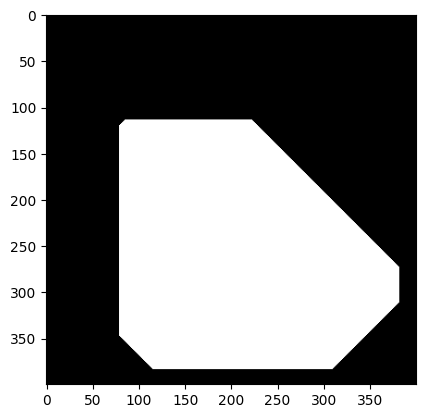

In [10]:
CH_cat = convex_hull_for_binary(perfectly_painted_cat)
plt.imshow(CH_cat, cmap="gray")
plt.show()